## Correlation Analysis

Irrigated area vs Nino 3.4 index and seasonal rainfall anomalies.  Plots a correlation matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [ ]:
#load in Nino 3.4 data and rearrange so its in the right format
nino34_monthly = pd.read_csv('data/NINO34ANOMS.csv', header=None, usecols=list(range(1,13)))
nino34_monthly = nino34_monthly.transpose()
nino34_monthly = pd.Series(nino34_monthly.values.ravel('F'))
dates = pd.date_range(start='1/1/1987', end='1/01/2020', freq='M')
nino34_monthly = pd.DataFrame({"date":dates, 'nino34_monthly': nino34_monthly}).set_index('date')

#get our irrigated area data, and geerate an anomaly timeseries from it
irr_area = pd.read_csv('results/nmdb_plots/csvs/NMDB_annual_area.csv')['irrigated area']
mean_area = irr_area.mean()
irr_anom = irr_area - mean_area

#load in rainfall anomaly data
rain = pd.read_csv('data/mdb_rainfall.csv')
rain = rain.drop([24,25])

In [ ]:
#resample the data to yearly means
nino34_yearly = nino34_monthly.resample('Y').mean()
nino34_yearly = nino34_yearly.drop(pd.DatetimeIndex(['2011-12-31', '2012-12-31']))
nino34_yearly = nino34_yearly.drop(nino34_yearly.index[[0]])

#resample the data to a custom length season
def group_customSummer(df, monthsInSeason = [11,12,1,2,3]):
    df['month'] = df.index.month
    summer = df['month'].isin(monthsInSeason)
    df = df.where(summer)
    df = df.dropna(axis=0, how="all")
    df = df.drop('month', axis=1)
    df = df.drop(df.index[[0,1]])
    df = df.rolling(5).mean()[::5]
    df = df.dropna(axis=0, how="all")
    return df

def group_customWinter(df, monthsInSeason = [11,12,1,2,3]):
    df['month'] = df.index.month
    summer = df['month'].isin(monthsInSeason)
    df = df.where(summer)
    df = df.dropna(axis=0, how="all")
    df = df.drop('month', axis=1)
    df = df.rolling(5).mean()[4::5]
    df = df.drop(df.index[[-1]])
#     df = df.dropna(axis=0, how="all")
    return df

nino34_winter = group_customWinter(nino34_monthly, monthsInSeason=[5,6,7,8,9])
nino34_summer = group_customSummer(nino34_monthly)
nino34_summer = nino34_summer.drop([pd.Timestamp('2012-03-31'), pd.Timestamp('2011-03-31')])
nino34_winter = nino34_winter.drop([pd.Timestamp('2012-09-30'), pd.Timestamp('2011-09-30')])

In [ ]:
#create one large dataframe with all possible independent variable
df = pd.DataFrame({'ninoSumm':list(nino34_summer.nino34_monthly),
                   'ninoWint':list(nino34_winter.nino34_monthly),
                   'ninoYear': list(nino34_yearly.nino34_monthly),
                   'RainSumm': list(rain.rain_anomaly_summer),
                   'RainWint': list(rain.rain_anomaly_winter),
                   'Irr_area': list(irr_area)
                  })
# df[0:23]

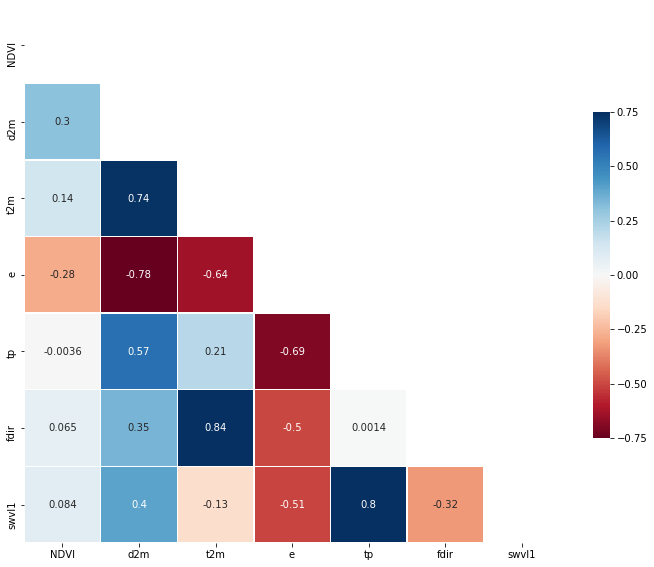

In [12]:
# Compute the correlation matrix using just the last 10 years (when MDB water allocations used)
corr_recent = df[23:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_recent, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr_recent, mask=mask, cmap='RdBu', vmin=-.75,vmax=.75, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr_early = df[0:23].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_early, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr_early, mask=mask, cmap='RdBu', vmin=-.75,vmax=.75, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})